## Code to:
- Load GPT2
- Print Early decoded output tokens for GPT2
Taken from here: https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/08a-mechanistic-interpretability.html

In [ ]:
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BloomTokenizerFast
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn

In [ ]:
def get_device():
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    return device

In [ ]:
def load_gpt2(version):
    device= get_device()
    tokenizer = AutoTokenizer.from_pretrained(version)
    model = AutoModelForCausalLM.from_pretrained(version, torch_dtype=torch.float16).to(device)
    return model, tokenizer

In [ ]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

In [ ]:
class ModelWrapper(nn.Module):

    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model.eval()
        self.model.activations_ = {}
        self.tokenizer = tokenizer
        self.device = get_device()
        self.num_layers = len(self.model.transformer.h)
        self.hooks  = []
        self.layer_pasts = {}

    def tokenize(self, s):
        return self.tokenizer.encode(s, return_tensors='pt').to(self.device)

    def list_decode(self, inpids):
        return [self.tokenizer.decode(s) for s in inpids]

    def layer_decode(self, hidden_states):
        raise Exception("Layer decode has to be implemented!")

    def get_layers(self, tokens, **kwargs):
        outputs = self.model(input_ids=tokens, output_hidden_states=True, **kwargs)
        hidden_states, true_logits = outputs.hidden_states, outputs.logits
        logits = self.layer_decode(hidden_states)
        #logits[-1] = true_logits.squeeze(0)[-1].unsqueeze(-1) #we used to just replace the last logits because we were applying ln_f twice
        return torch.stack(logits).squeeze(-1)#, true_logits.squeeze(0)

    def get_layers_w_attns(self, tokens, **kwargs):
        outputs = self.model(input_ids=tokens, output_hidden_states=True, output_attentions=True, **kwargs)
        hidden_states, true_logits = outputs.hidden_states, outputs.logits
        logits = self.layer_decode(hidden_states)
        #logits[-1] = true_logits.squeeze(0)[-1].unsqueeze(-1)
        return torch.stack(logits).squeeze(-1), outputs.attentions#, true_logits.squeeze(0)

    def rr_per_layer(self, logits, answer, debug=False):
        #reciprocal rank of the answer at each layer
        answer_id = self.tokenizer.encode(answer)[0]
        if debug:
            print("Answer id", answer_id, answer)

        rrs = []
        for i,layer in enumerate(logits):
            soft = F.softmax(layer,dim=-1)
            sorted_probs = soft.argsort(descending=True)
            rank = float(np.where(sorted_probs.cpu().numpy()==answer_id)[0][0])
            rrs.append(1/(rank+1))

        return np.array(rrs)

    def prob_of_answer(self, logits, answer, debug=False):
        answer_id = self.tokenizer.encode(answer)[0]
        if debug:
            print("Answer id", answer_id, answer)
        answer_probs = []
        first_top = -1
        mrrs = []
        for i,layer in enumerate(logits):
            soft = F.softmax(layer,dim=-1)
            answer_prob = soft[answer_id].item()
            sorted_probs = soft.argsort(descending=True)
            if debug:
                print(f"{i}::", answer_prob)
            answer_probs.append(answer_prob)
        #is_top_at_end = sorted_probs[0] == answer_id
        return np.array(answer_probs)

    def print_top(self, logits, k=10):
        for i,layer in enumerate(logits):
            print(f"{i}", self.tokenizer.decode(F.softmax(layer,dim=-1).argsort(descending=True)[:k]) )

    def topk_per_layer(self, logits, k=10):
        topk = []
        for i,layer in enumerate(logits):
            topk.append([self.tokenizer.decode(s) for s in F.softmax(layer,dim=-1).argsort(descending=True)[:k]])
        return topk

    def get_activation(self, name):
        #https://github.com/mega002/lm-debugger/blob/01ba7413b3c671af08bc1c315e9cc64f9f4abee2/flask_server/req_res_oop.py#L57
        def hook(module, input, output):
            if "in_sln" in name:
                num_tokens = list(input[0].size())[1]
                self.model.activations_[name] = input[0][:, num_tokens - 1].detach()
            elif "mlp" in name or "attn" in name or "m_coef" in name:
                if "attn" in name:
                    num_tokens = list(output[0].size())[1]
                    self.model.activations_[name] = output[0][:, num_tokens - 1].detach()
                    self.model.activations_['in_'+name] = input[0][:, num_tokens - 1].detach()
                elif "mlp" in name:
                    num_tokens = list(output[0].size())[0]  # [num_tokens, 3072] for values;
                    self.model.activations_[name] = output[0][num_tokens - 1].detach()
                elif "m_coef" in name:
                    num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                    self.model.activations_[name] = input[0][:, num_tokens - 1].detach()
            elif "residual" in name or "embedding" in name:
                num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                if name == "layer_residual_" + str(self.num_layers-1):
                    self.model.activations_[name] = self.model.activations_[
                                                        "intermediate_residual_" + str(final_layer)] + \
                                                    self.model.activations_["mlp_" + str(final_layer)]

                else:
                    if 'out' in name:
                        self.model.activations_[name] = output[0][num_tokens-1].detach()
                    else:
                        self.model.activations_[name] = input[0][:,
                                                            num_tokens - 1].detach()

        return hook

    def reset_activations(self):
        self.model.activations_ = {}

In [ ]:
class GPT2Wrapper(ModelWrapper):

    def layer_decode(self, hidden_states):
        logits = []
        for i,h in enumerate(hidden_states):
            h=h[:, -1, :] #(batch, num tokens, embedding size) take the last token
            if i == len(hidden_states)-1:
                normed = h #ln_f would already have been applied
            else:
                normed = self.model.transformer.ln_f(h)
            l = torch.matmul(self.model.lm_head.weight, normed.T)
            logits.append(l)
        return logits

    def add_hooks(self):
        for i in range(self.num_layers):
            #intermediate residual between
            #print('saving hook')
            self.hooks.append(self.model.transformer.h[i].ln_1.register_forward_hook(self.get_activation(f'in_sln_{i}')))
            self.hooks.append(self.model.transformer.h[i].attn.register_forward_hook(self.get_activation('attn_'+str(i))))
            self.hooks.append(self.model.transformer.h[i].ln_2.register_forward_hook(self.get_activation("intermediate_residual_" + str(i))))
            self.hooks.append(self.model.transformer.h[i].ln_2.register_forward_hook(self.get_activation("out_intermediate_residual_" + str(i))))
            self.hooks.append(self.model.transformer.h[i].mlp.register_forward_hook(self.get_activation('mlp_'+str(i))))
            #print(self.model.activations_)


    def get_pre_wo_activation(self, name):
        #wo refers to the output matrix in attention layers. The last linear layer in the attention calculation

        def hook(module, input, output):
            #use_cache=True (default) and output_attentions=True have to have been passed to the forward for this to work
            _, past_key_value, attn_weights = output
            value = past_key_value[1]
            pre_wo_attn = torch.matmul(attn_weights, value)
            self.model.activations_[name]=pre_wo_attn

        return hook

    def get_past_layer(self, name):
        #wo refers to the output matrix in attention layers. The last linear layer in the attention calculation

        def hook(module, input, output):
            #use_cache=True (default) and output_attentions=True have to have been passed to the forward for this to work
            #print(len(output), output, name)
            _, past_key_value, attn_weights = output
            self.layer_pasts[name]=past_key_value

        return hook

    def add_mid_attn_hooks(self):
        for i in range(self.num_layers):
            self.hooks.append(self.model.transformer.h[i].attn.register_forward_hook(self.get_pre_wo_activation('mid_attn_'+str(i))))

            self.hooks.append(self.model.transformer.h[i].attn.register_forward_hook(self.get_past_layer('past_layer_'+str(i))))

    def rm_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def reset_activations(self):
        self.activations_ = {}
        self.last_pasts = {}

In [ ]:
model, tokenizer = load_gpt2('gpt2-medium')
model = model.float()

In [ ]:
wrapper = GPT2Wrapper(model, tokenizer)
def tokenize(text):
    inp_ids = wrapper.tokenize(text)
    str_toks = wrapper.list_decode(inp_ids[0])
    return inp_ids, str_toks

In [ ]:
poland_text="""Q: What is the capital of France?
A: Paris
Q: What is the capital of Poland?
A:"""

poland_ids, pol_toks = tokenize(poland_text)

In [ ]:
poland_ids.shape

torch.Size([1, 26])

In [ ]:
logits = wrapper.get_layers(poland_ids)
wrapper.print_top(logits[1:]) #skip the embedding layer

0  ( [ The:,
 at and Act A
1  A The ( [ Is59
 At and40
2  A [ ( The At Is Act at59,
3  A [ ( Act At Is The CH An at
4  A [ At Q (Q The Are M An
5  A M No At The payable Q Qu (Q
6  No M A The C Die An H En Qu
7  C A No The M n P N H An
8  A The C P H No n Ass N T
9  A C No nil The Ch P An H N
10  A The G C N P No Me An Le
11  A C N None P G The Pr Ce H
12  Unknown None C G A N Bar The Ch P
13  C P N G B A Unknown St None The
14  St N G P Poland B C Pol A D
15  Poland P St Pol Warsaw Polish N B G Germany
16  Poland Warsaw Polish Poles Budapest Prague Pol Germany Berlin Moscow
17  Poland Warsaw Polish Poles Budapest Prague � Pol Lithuania Moscow
18  Poland Warsaw Polish Prague Budapest Poles Moscow � Berlin Kiev
19  Warsaw Poland Polish Budapest Prague Moscow Berlin Kiev � Frankfurt
20  Warsaw Poland Prague Budapest Polish Moscow Kiev Berlin Frankfurt Brussels
21  Warsaw Poland Polish Prague Budapest � Kiev Sz Berlin Moscow
22  Warsaw Poland Prague Budapest K W Kiev Sz Moscow Berlin
23  W

In [ ]:
logits.shape

torch.Size([25, 50257])

In [ ]:
germany_text="""Q: What is the capital of France?
A: Paris
Q: What is the capital of Germany?
A:"""

In [ ]:
german_ids, german_toks = tokenize(germany_text)

In [ ]:
german_ids.shape

torch.Size([1, 26])

In [ ]:
logits = wrapper.get_layers(german_ids)
wrapper.print_top(logits[1:]) #skip the embedding layer

0  ( [ The: at,
 and A Act
1  A The ( [ Is59
 At40 and
2  A [ ( The At Is Act at59,
3  A [ ( At Act Is The CH An40
4  A [ At Q The (Q M Are An
5  A M No At The payable Q ( Qu En
6  M No A The C Die An H En At
7  C A No The M P n H N An
8  A The C H P Ass n No N Ch
9  A C Ch The nil No H P An N
10  A The C Le G Ch N Me P Panama
11  A C N G The P None Pr Ch Ce
12  C A None G The Ch N Bar Unknown St
13  C G N B St A P The Ce Bar
14  Germany Berlin St G London Paris N B A P
15  Germany Berlin St London Vienna Paris G B Cologne D
16  Germany Berlin Cologne Frankfurt Munich Vienna Paris Hamburg London Zurich
17  Germany Berlin Frankfurt Munich Cologne Hamburg Vienna German Zurich Bav
18  Berlin Germany Frankfurt Hamburg Munich Cologne Vienna Zurich Paris Amsterdam
19  Berlin Frankfurt Germany Munich Hamburg Cologne Vienna Zurich Stockholm Gö
20  Berlin Frankfurt Munich Cologne Germany Hamburg Zurich Dortmund Vienna Dresden
21  Berlin Munich Frankfurt Germany Cologne Hamburg Dortmund Dresden 

In [ ]:
def print_logits_progression(text):
  ids, toks = tokenize(text)
  logits = wrapper.get_layers(ids)
  wrapper.print_top(logits[1:])

# Case-1: Incomplete Sentence

In [ ]:
print_logits_progression("Hi, My name is")

0  not also in currently often definitely a generally the typically
1  not also currently often typically definitely in required bound now
2  not also in expected currently now definitely: often,
3  not in currently now:, definitely probably also a
4  not in: the, a being now at definitely
5  not definitely in the a probably listed: now currently
6  not in being definitely a the important as [:
7  not in the, one definitely so a probably:
8  not, in now a the so one probably definitely
9  ______ not proud my the T, so a in
10  ______ not, my the a so proud happy in
11  ______ a my not the proud My K, Y
12  ______ a Y my K My the Chairman Michael John
13  John ______ Michael Nick the K Y a my William
14  Nick John Michael ______ David Tom William Brian Joe Robert
15  John Michael Nick ______ Mary William Sam Daniel David Joseph
16  John Michael William David Sam Daniel Joseph Nick Mike Adam
17  John Michael Daniel William David Tom Mike Sam Adam Joseph
18  John Michael Mike Chris Tom Jo

# Case - 2: Garbage Sentence

In [ ]:
print_logits_progression("💓⭐🌹Hermanita")

0  Nita� Lynn Pikaq  Hydeo
1  Nq Lynn P K� sigi T Nu
2  N Nu Lynnire P Levy K Linda Maria T
3  N Lynn Levy P Proire T Linda Maria Li
4  N Levy Lynn Pro P, Klire T Tek
5  N Levyqueques Lynnire P Pro Kl,
6 quesque Nires P Levy K enire Pro
7 , P-ires ( N Pol B:ire
8 , P ( Liires N A- F B
9  P Li (, K- N B F's
10 , ( P's N- F K B:
11 , ('s B P-.: K N
12 , ( P B.- K's N L
13 , ( N. P K's B S-
14 ,® P ( N-'s™ B.
15 ®,'s™ (:- L P Species
16 ®™ Species's, L P ( B:
17 ™® Speciesaceae species's- B  s
18  Species™ s® n species L's B ver
19  Species s n ver species L et c™'s
20  s n ver le c b m sp  da
21  s sp n f c le  ver k da
22  n s sp f c  b, ch (
23  s
 sp  c mus ( n f m


# Case - 1b: Incomplete Sentence (with unclear subject of interest)

In [ ]:
print_logits_progression("Thank bhai love you ")

0   -- lirc Ven ( R TABLE Ad
1    Dism TABLEirc Russia Syria Iran R Istanbul
2    Iranirc I Radio TABLE R Ad Dism
3   xt am Nep Syria ad Leninirc I
4    Syria Nep amircxtute ad Open
5   Syria ircxt
 Go am I Open
6  ircxt Gouteilt
 Syriaorism
7 irc orsoandnan Goxtipsute
8  orircand Goummute Fxt

9  ircandxtorips!!! i Fiversity
10  andircorxt!!!iversitynanIips
11  iversity!!!ircnanorxtandIips
12  !!!andiversityorxtircnanuthI
13 !!! xtandiversityoripsс____________________
14 !!!xt ips____________________!!!!urnirl�
15 !!!!!!!xt________________ ____�irl�''
16 !!!!!!!�xt____irl________________ �********
17 !!!!!!!��irl???? ____xt!!!!!!!!
18 !!!!!!!!!!!!!!!!!��???? ~~~~!"
19 !!!!!!!!!!!!!!!!!��!"irl????____
20 !!!!!!!!!!!!!!!!!�!"�????irl~~~~
21 !!!!!!!!"!!!!!!!!!!irl!????��
22 !!!!"!!!!!!!!!!!!!!�?"�."」
23 !"!!!!!!!�!!!!!!!!ive?"」�!!


#Intuition:
There are some patterns using which we can determine if the model would be able to assess whether a given input is unclear and cannot provide a definite completion to the input.

## Method 1:
- The raw probability of the token predicted (should be lower than average for unclear queries than for normal.)

## Method 2:
- The lack of spike in `max-output probability` that happens at some middle layer that happens for clear input queries and not for unclear queries.

## Method 3:
- The most likely token keeps changing.

In [ ]:
# simple queries.
simple_clean_queries = [
    "The capital of France is",
    "The color of sky is",
    "Sometimes, I wonder about",
    "The best cab service is",
    "What is going?"
]

# unclear queries.
unclear_queries = [
    "qqxqxhnwndwd",
    "chng kommuni",
    "his what me some",
    "Response wen 2 sorry",
    "----,--,-,-,-,-,/-,(----hat ,--==ACOSH =="
]

In [ ]:
class GPT2IntermediateDictWrapper(GPT2Wrapper):
    """
    Extends ModelWrapper with a method that, given per‐layer logits,
    returns a dict mapping each decoded token → { layer_idx: softmax‐prob }.
    """
    def per_token_layer_probs(self, logits: torch.Tensor, top_k: int = 10) -> dict:
        """
        Args:
            logits: Tensor of shape [num_layers, vocab_size], e.g. from get_layers(...)
            top_k:   how many highest-prob tokens to keep based on final layer
        Returns:
            Dict[token_str, { layer_idx: probability, … }]  only for top_k tokens by final-layer prob
        """
        # convert logits -> probabilities per layer
        probs = F.softmax(logits, dim=-1)  # [num_layers, vocab_size]
        num_layers, vocab_size = probs.shape

        # find top_k tokens in the final layer
        final_layer_probs = probs[-1]  # [vocab_size]
        topk_vals, topk_ids = final_layer_probs.topk(top_k)

        result = {}
        # for each selected token, collect its prob across all layers
        for tok_id in topk_ids.tolist():
            tok_str = self.tokenizer.decode([tok_id]).strip()
            # build layer->prob mapping
            layer_map = {
                layer: probs[layer, tok_id].item()
                for layer in range(num_layers)
            }
            result[tok_str] = layer_map

        return result

    def get_token_probs(self, tokens, top_k: int = 10, **kwargs) -> dict:
        """
        Convenience wrapper: run get_layers and immediately produce the nested
        token -> { layer: prob } map, only for the top_k tokens by final-layer prob.
        """
        logits = self.get_layers(tokens, **kwargs)  # [L, vocab_size]
        return self.per_token_layer_probs(logits, top_k=top_k)

In [ ]:
wrapper_ext = GPT2IntermediateDictWrapper(model, tokenizer)

In [ ]:
def tokenize_ext(text):
    inp_ids = wrapper_ext.tokenize(text)
    str_toks = wrapper_ext.list_decode(inp_ids[0])
    return inp_ids, str_toks

In [ ]:
def get_token_layer_dictionary(text):
  ids, toks = tokenize(text)
  logits = wrapper_ext.get_layers(ids)
  return wrapper_ext.per_token_layer_probs(logits), len(logits)

In [ ]:
import matplotlib.pyplot as plt

def visualize_token_prob_dist_for_query(text, ax):
    token_layer_dict, num_layers = get_token_layer_dictionary(text)
    x_axis = list(range(num_layers))

    for token in token_layer_dict.keys():
        y_axis = []
        for layer in range(num_layers):
            y_axis.append(token_layer_dict[token].get(layer, 0))
        ax.plot(x_axis, y_axis, label=token)

    ax.set_title(f"Text: {text}")
    ax.legend()

In [ ]:
def visualize_together(texts):
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  # Flatten axes array for easy iteration
  axes = axes.flatten()
  for idx, text in enumerate(texts):
    visualize_token_prob_dist_for_query(text, axes[idx])
    axes[idx].set_title(text)
  plt.tight_layout()
  plt.show()

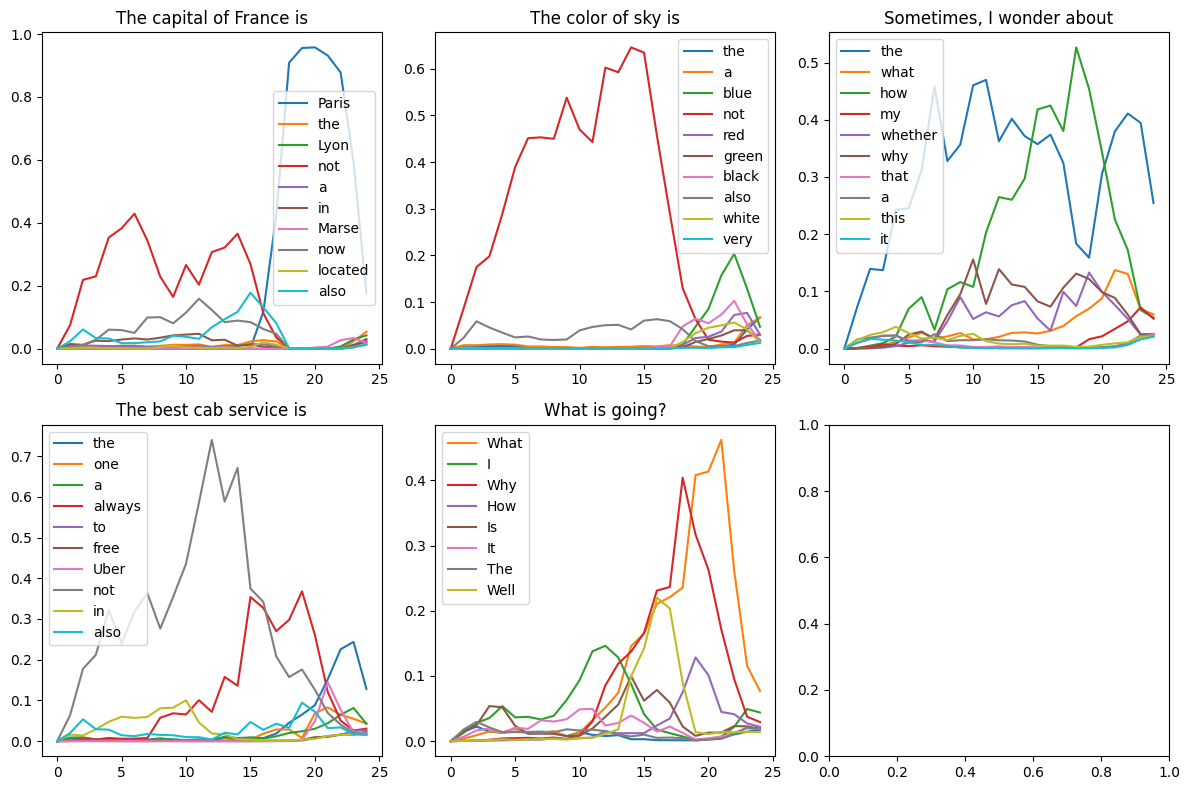

In [ ]:
visualize_together(simple_clean_queries)

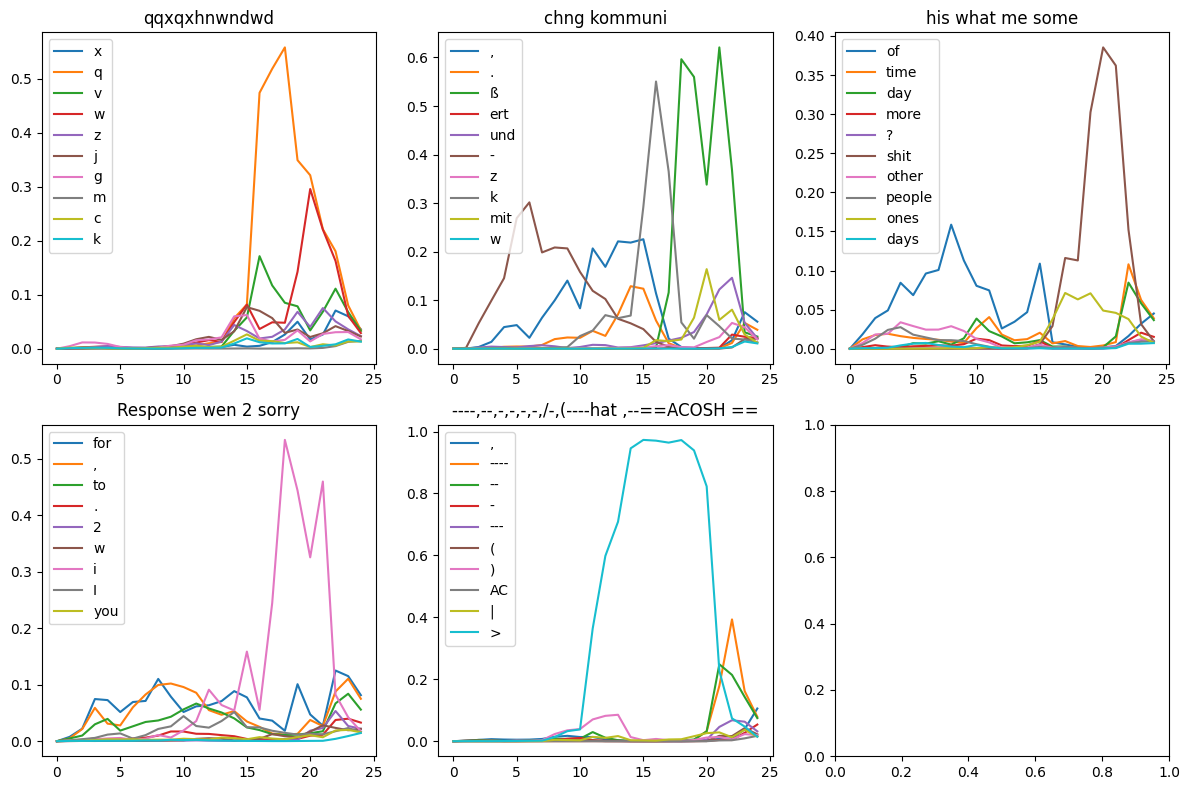

In [ ]:
visualize_together(unclear_queries)

In [ ]:
def visualize_together_with_augmentation(texts):
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  # Flatten axes array for easy iteration
  axes = axes.flatten()
  for idx, text in enumerate(texts):
    prompt = "Complete the sentence: " + text
    visualize_token_prob_dist_for_query(prompt, axes[idx])
    axes[idx].set_title(text)
  plt.tight_layout()
  plt.show()

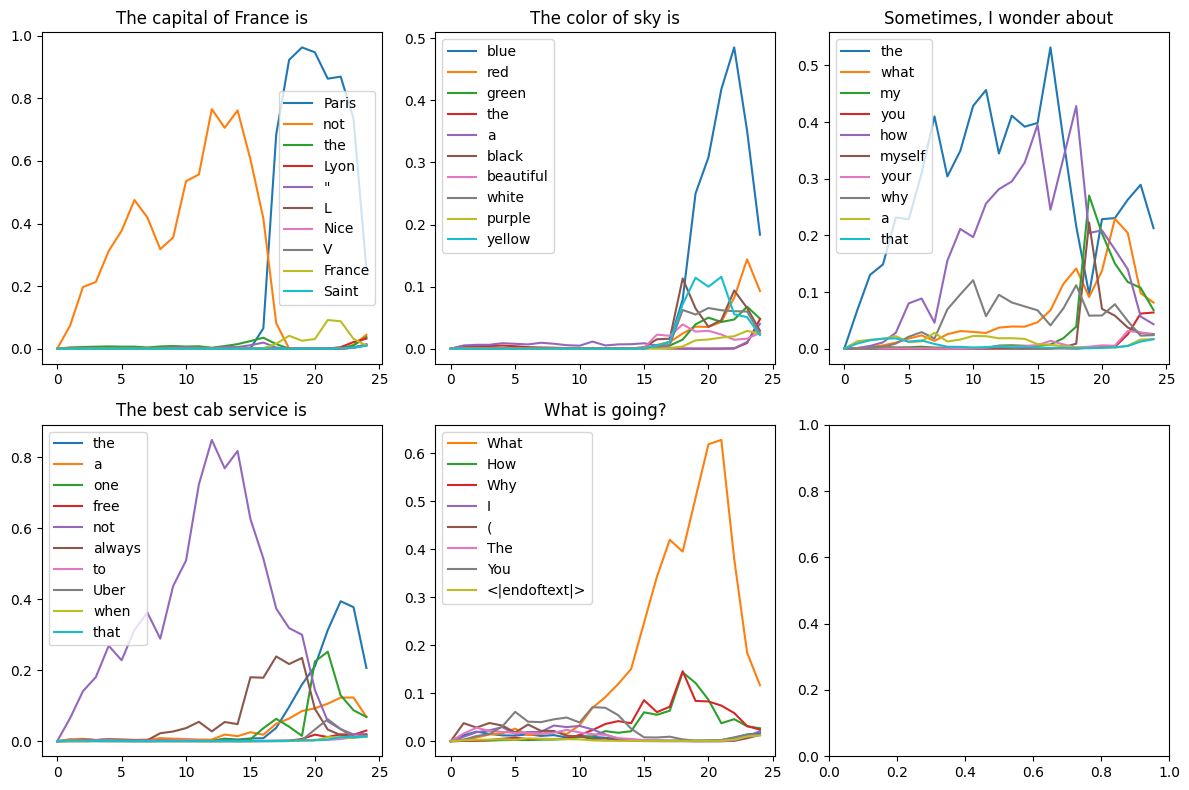

In [ ]:
visualize_together_with_augmentation(simple_clean_queries)

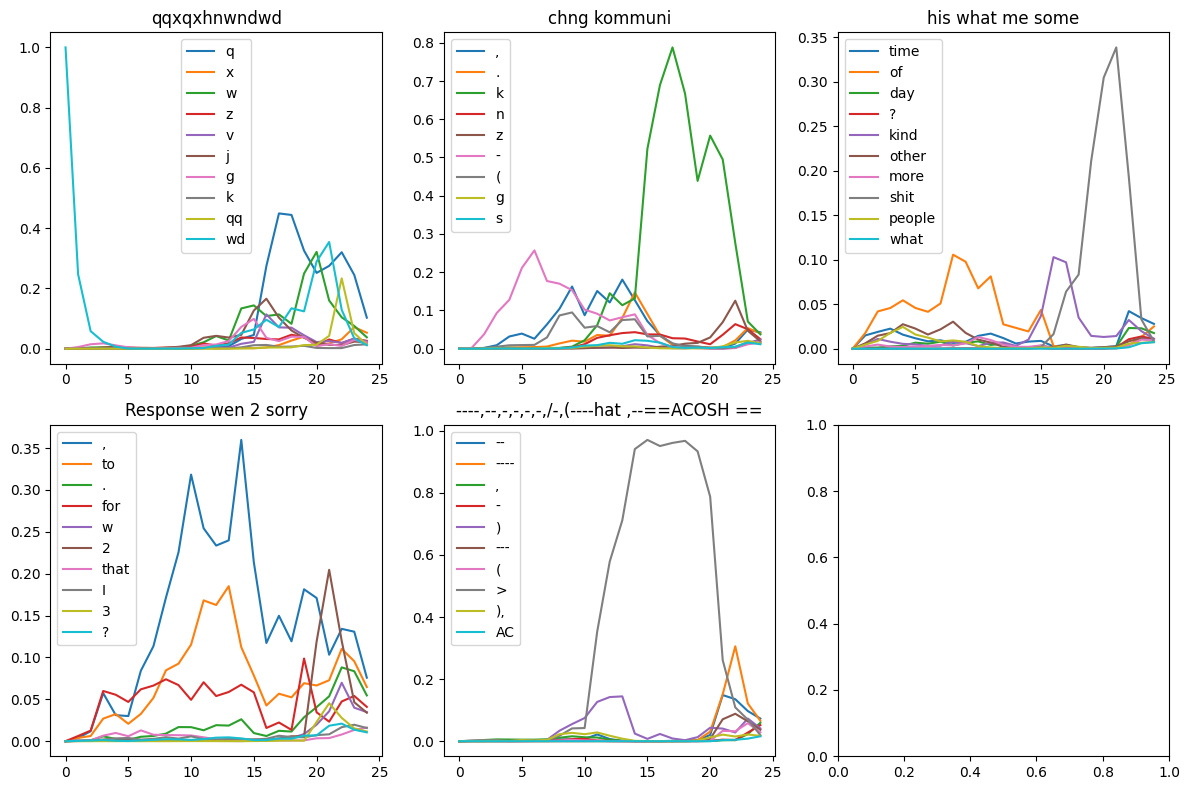

In [ ]:
visualize_together_with_augmentation(unclear_queries)

# Some Observations:
- The final probability of `max-prob token` in the case of "unclear queries" ranks slightly lower than normal ones. (like < 0.1 vs >= 0.2)

- If none of the tokens cross (> 0.3 probability) in any layer of the sequence, then we can state that the query is 'unclear'.

- The simplistic answer like "Paris" or "blue" has higher probability before more operations occur in later layers which probably act as safeguards against model's assumptions. (this is GPT-2, so let's take this with a HUGE grain of salt)

